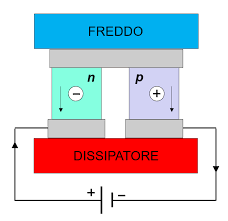

In [ ]:
from IPython.display import Image, display

images = [
    Image("Media/Cella di Pelteir.png")
]
display(*images)

## Celle di Peltier

### 1) Configurazione della lettura seriale PR59
- Abbiamo usato la libreria "pyserial" con modulo "Serial"

- Abbiamo overclocckato la priorità usando il modulo "psutil.Process" perchè ci siamo accorti che abbassando la finestra dell'output di python cambiasse la priorità che il sistema dedicasse al programma, con conseguenza che aumentasse la frequenza di correzione della temperatura del PID e questo non lo volevamo

- Abbiamo modificato il programma per renderlo disponibile ad accettare comandi durante l'esecuzione del programma

----
### 2) Strumenti e ciclo di misura

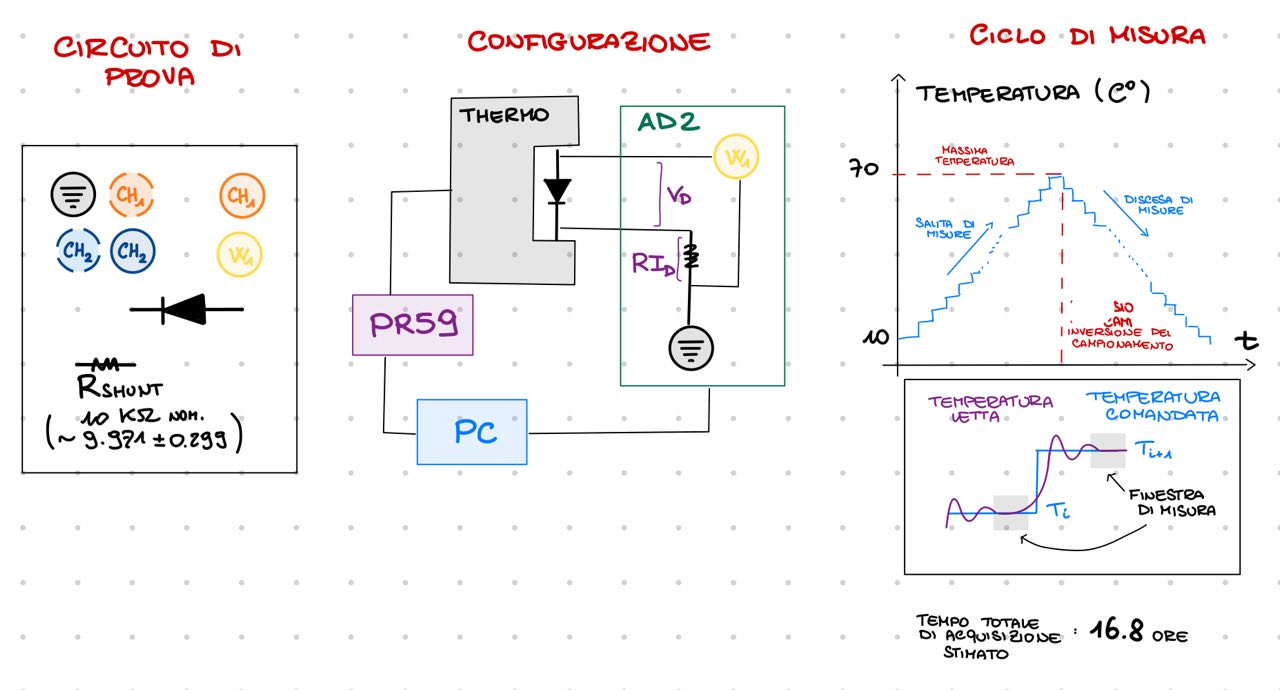

In [13]:
images = [
    Image("Media/Framework.jpg",width=1000)
]
display(*images)

Descrizione del ciclo di misura
- Per ogni temperatura vengono effettuati due sweep in tensione $V_{go}$ e $V_{return}$
- Vengono effettuati un ciclo di temperatura di salita e di discesa

----
### Test del funzionamento del diodo
Osserviamo la temperatura $T$ dal controller della temperatura seriale contemporaneamente corrente $I_d$ e tensione $V$ tramite AD2.

- Abbiamo effettuato in primis delle misure rapide con un diodo "di prova" per vedere se il setting fosse correttamente costruito


$R=9.971 \pm 0.299 k\Omega$

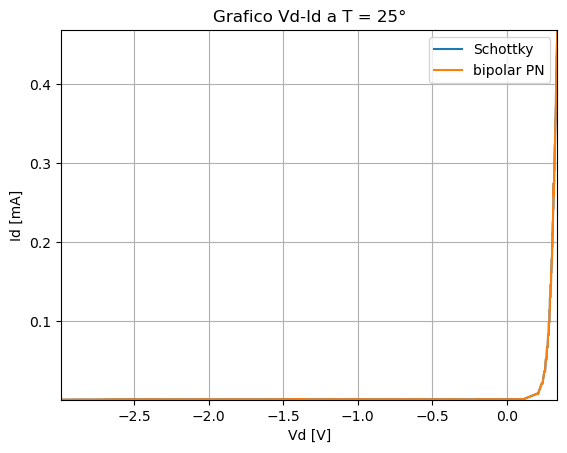

In [38]:
import numpy as np
from matplotlib import pyplot as plt

def U(data):
    Vcc, Vd_Go, Vd_Return, Id_Go, Id_Return = data
    V = np.concatenate((Vd_Go, Vd_Return))
    I = np.concatenate((Id_Go, Id_Return))
    idx = np.argsort(V)
    V = V[idx]
    I = I[idx]*1e3
    return V,I

def UU(data):
    Td_go, Td_return, Vc, Vd_go, Vd_return, ErrVd_go, ErrVd_return, Vr_go, Vr_return, ErrVr_go, ErrVr_return, Id_go, Id_return, ErrId_go, ErrId_return = data
    V = np.concatenate((Vd_Go, Vd_Return))
    I = np.concatenate((Id_Go, Id_Return))
    idx = np.argsort(V)
    V = V[idx]
    I = I[idx]*1e3
    return V,I

data = np.loadtxt("Data/IV-T_dependence_20250404_100546/IV_T25.00_V-1.00_5.00_0Pull_TGo.txt",unpack=True)
V_bipolar, I_bipolar = UU(data)

data = np.loadtxt("Data/IV-T_dependence_20250408_110423/IV_T25.00_V-1.00_5.00_0Pull_TGo.txt",unpack=True)
V_Schottky, I_Schottky = UU(data)

#data = np.loadtxt("Data/IV-T_dependence_20250408_124236/IV_T25.00_V-1.00_5.00_0Pull_TGo.txt",unpack=True)
#V_Zener33, I_Zener33 = UU(data)

# Grafico
plt.plot(V_Schottky, I_Schottky, label="Schottky")
plt.plot(V_bipolar, I_bipolar, label="bipolar PN")
#plt.plot(V_Zener27, I_Zener27, label="Zener 2.7")
#plt.plot(V_Zener33, I_Zener33, label="Zener 3.3")
plt.title("Grafico Vd-Id a T = 25°")
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel("Vd [V]")
plt.ylabel("Id [mA]")
plt.legend()
plt.grid()
plt.show()

- "IV-T_dependence_20250404_100546" è la cartella con presa dati completa del diodo PN
- "IV-T_dependence_20250408_110423" è la cartella con presa dati completa del diodo Shottky
- "IV-T_dependence_20250408_124236" è la cartella con presa dati completa del diodo Zener 3.3

-----
### Risposta del diodo al variare della temperatura
Vorremmo fittare la seguente funzione:

$\boxed{I_d = I_s\left[ e^{\frac{eV}{\eta k_B T}}-1\right]}$ con in generale una corrente di saturazione $\boxed{I_s = I_0 T^\gamma e^{\frac{E_0}{\eta k_B T}}}$:

- $\text{\textbf{Modello di Shockley}}$: per un diodo bipolare consideriamo:
    - Esponente: $\gamma = \frac{3}{2}$, 
    - Energia di ground state: $E_0 \approx 1.1 eV$, 
    - Fattore di idealità: $\eta \in [1,2]$

- $\text{\textbf{Modello di Richardson}}$: per un diodo unipolare consideriamo:
    - Esponente: $\gamma = 2$, 
    - Altezza della barriera Schottky: $E_0$, 
    - Fattore di idealità: $\eta =1$

$\text{\textbf{Modello Zener}}$: per un diodo zener consideriamo:

$\boxed{I(V, T) \approx
\begin{cases}
I_s(T) \left( e^{\frac{qV}{n k T}} - 1 \right) & \text{se}\quad V > 0 \\
-I_s(T) \left( e^{\frac{-q(V + V_Z(T))}{n k T}} - 1 \right) & \text{se}\quad  V < -V_Z(T) \\
I_\text{leak}(T) & \text{se}\quad  -V_Z(T) < V < 0
\end{cases}}$

con:
- $\boxed{I_s(T) = I_0 T^2 e^{\frac{-E_g}{k_B T}} }$ (comportamento Schottky)

- $\boxed{V_Z(T) = V_Z(T_0) + \Delta V_Z(T-T_0) }$ (voltaggio di soglia comportamento Zener)

- $\boxed{I_{leak}(T) = I_{leak}(T_0) T^2 e^{\frac{-E_g}{k_B T}} }$ con $I_{leak}(T_0)\ll I_0\quad$ (corrente di fuga inversa)

Effettueremo le seguenti scelte:
- Spezziamo i dati dello Zenner nelle tre aree e le fitteremo separatamente
- Fissiamo un valore $T_0\approx 35°$ circa in mezzo all'intervallo di temperatura e trascuriamo $\Delta V_Z(T-T_0)$
- Consideriamo $I_{leak}(T)\approx I_{leak}(T_0)$ data la slope molto bassa